# Adversarial Attack on Privacy - Record Linkage Analysis

This notebook implements a multi-stage approach to re-identify records in a protected dataset by linking them to an original dataset. It includes feature engineering, similarity matching, ML-based refinement, transformation/noise analysis, distance-based refinement, and vulnerability quantification (epsilon estimation).



## 1. Imports and Configuration

Import necessary libraries and set up configuration parameters.



In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats import norm, laplace
import warnings


USE_ML_REFINEMENT = True
TOP_K_CANDIDATES_FOR_ML = 5 # How many candidates per record to check with ML
MIN_SAMPLES_FOR_NOISE_FIT = 50 # Minimum high-conf samples needed to fit noise


# Define the maximum possible change (L1 sensitivity) for key numerical attributes.
# These are *guesses* and must be justified based on domain knowledge or data exploration.
SENSITIVITY_ASSUMPTION = {
    'Income': 100000,
    'Rent': 20000,
    'Loan_Repayment': 50000,
    'Insurance': 5000,
    'Groceries': 5000,
    'Transport': 3000,
    'Eating_Out': 4000,
    'Entertainment': 4000,
    'Utilities': 2000,
    'Healthcare': 10000,
    'Education': 20000,
    'Miscellaneous': 5000,
    'Default': 10000
}


#  Display Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("all set")

all set


## 2. Load Data

Load the original and protected datasets.

In [3]:
protected_data = pd.read_csv('protected_data_challenge.csv')
original_data = pd.read_csv('data-challenge-original.csv')

#  Print the shapes (number of rows and columns)
print(f"Protected data shape: {protected_data.shape}")
print(f"Original data shape: {original_data.shape}")

#  Show first 3 rows of protected data
print("\nProtected Data (First 3 rows):")
print(protected_data.head(3))

#  Show first 3 rows of original data
print("\nOriginal Data (First 3 rows):")
print(original_data.head(3))

Protected data shape: (20000, 18)
Original data shape: (20000, 18)

Protected Data (First 3 rows):
                         Identifier                              Name  Age  \
0  bb0fe6d06cc153b8635440fd3638b589  c8b4c30e6fcdbaa4e0d1c3db732cb222   23   
1  9f8921b372a89bdb616b822e3137e87d  afdff0db61720290465c6e30ac45ba92   48   
2  6b8de0031bb7c14e2d4a9305c5c50b23  2b379af688ea4197b678316f376d1764   30   

      Occupation City_Tier  Dependents    Income     Rent  Loan_Repayment  \
0        Retired    Tier_2           3  25166.00  5065.18            0.22   
1  Self_Employed    Tier_2           0  21709.45  4313.33            1.66   
2        Retired    Tier_2           2  40669.25  8160.43         4471.97   

   Insurance  Groceries  Transport  Eating_Out  Entertainment  Utilities  \
0     568.09    3126.91    2002.14      757.03         815.29    1940.71   
1     468.73    2534.51    1457.48      814.66         947.51    1045.55   
2    1201.45    6021.28    2998.56     1275.74     

## 3. Step 1: Feature Engineering

Define and apply a function to create distinctive "fingerprints" for each record. These include ratios, composite features, outlier flags, and spending patterns, designed to be robust against some anonymization techniques.

In [4]:

print("Step 1: Defining fingerprinting function...")

def create_fingerprints(df):
    """Create distinctive fingerprints for each row"""
    df_features = df.copy()
    expense_columns = ['Rent', 'Loan_Repayment', 'Insurance', 'Groceries',
                       'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
                       'Healthcare', 'Education', 'Miscellaneous']
    # Ensure only columns present in the dataframe are used
    valid_expense_cols = [col for col in expense_columns if col in df_features.columns]

    # Calculate expense ratios
    if 'Income' in df_features.columns:
        df_features['Income_temp'] = df_features['Income'].replace(0, np.nan) # Temp column
        for col in valid_expense_cols:
             df_features.loc[df_features['Income_temp'].notna(), f'{col}_ratio'] = df_features[col] / df_features['Income_temp']
             df_features[f'{col}_ratio'] = df_features[f'{col}_ratio'].fillna(0)
        df_features = df_features.drop(columns=['Income_temp']) # Drop temp column
    else:
        print("Warning: 'Income' column not found for ratio calculation.")


    # Create demographic composite features
    if 'Age' in df_features.columns and 'Dependents' in df_features.columns:
        df_features['age_dependents'] = df_features['Age'] * (df_features['Dependents'] + 1)

    # Create occupation-tier composite
    if 'Occupation' in df_features.columns and 'City_Tier' in df_features.columns:
        df_features['occ_tier'] = df_features['Occupation'].astype(str) + '_' + df_features['City_Tier'].astype(str)

    # Flag unusual values (outliers)
    numeric_cols_for_outliers = ['Income'] + valid_expense_cols
    numeric_cols_for_outliers = [col for col in numeric_cols_for_outliers if col in df_features.columns] # Filter existing
    for col in numeric_cols_for_outliers:
        q1 = df_features[col].quantile(0.25)
        q3 = df_features[col].quantile(0.75)
        iqr = q3 - q1
        if iqr > 0:
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            df_features[f'{col}_outlier'] = ((df_features[col] < lower_bound) | (df_features[col] > upper_bound)).astype(int)
        else: # Handle cases with zero IQR (e.g., all values the same)
            median_val = df_features[col].median()
            df_features[f'{col}_outlier'] = (df_features[col] != median_val).astype(int)


    # Create expense pattern fingerprint (rank expenses)
    if valid_expense_cols:
        try:
            # Ensure expenses are numeric, fillna with 0 temporarily for sorting robustnes
            expense_data_numeric = df_features[valid_expense_cols].fillna(0).apply(pd.to_numeric, errors='coerce')
            expense_pattern = expense_data_numeric.apply(lambda x: pd.Series(sorted(x.dropna(), reverse=True)), axis=1)
            # Rename columns safely, ensuring we don't exceed available ranks
            num_ranks = expense_pattern.shape[1]
            expense_pattern.columns = [f'expense_rank_{i}' for i in range(num_ranks)]
            df_features = pd.concat([df_features, expense_pattern], axis=1)
            # Fill NaNs that might arise if a row had fewer expenses than the max number of ranks
            rank_cols = [f'expense_rank_{i}' for i in range(num_ranks)]
            for r_col in rank_cols:
                 if r_col in df_features.columns:
                     df_features[r_col] = df_features[r_col].fillna(0) # Fill potential NaNs with 0
        except Exception as e:
             print(f"Warning: Could not create expense rank features. Error: {e}")


    # Zero-value pattern (which categories have near-zero values)
    for col in valid_expense_cols:
        # Ensure column is numeric before comparison
        if pd.api.types.is_numeric_dtype(df_features[col]):
            df_features[f'{col}_near_zero'] = (df_features[col] < 10).astype(int)
        else:
             df_features[f'{col}_near_zero'] = 0 # Or handle non-numeric appropriately

    return df_features


protected_features = create_fingerprints(protected_data)
original_features = create_fingerprints(original_data)
print("Fingerprints created.")
print(f"Protected features shape: {protected_features.shape}")
print(f"Original features shape: {original_features.shape}")


Step 1: Defining fingerprinting function...
Fingerprints created.
Protected features shape: (20000, 65)
Original features shape: (20000, 65)


## 4. Step 2: Calculate Similarity Scores

Define and apply a function to calculate the cosine similarity between all pairs of protected and original records based on their numerical fingerprints. Standard scaling is applied first.

In [5]:


def calculate_similarity(protected_df, original_df):
    """Calculate similarity scores between protected and original rows"""
    # Select numerical features present in BOTH dataframes
    common_cols = protected_df.columns.intersection(original_df.columns)
    numerical_cols = [col for col in common_cols
                     if pd.api.types.is_numeric_dtype(protected_df[col])
                     and pd.api.types.is_numeric_dtype(original_df[col])]
    print(f"Using {len(numerical_cols)} numerical columns for similarity calculation.")
    # print(f"Columns used: {numerical_cols}")

    if not numerical_cols:
        raise ValueError("No common numerical columns found between the dataframes.")

    # Select and fill NaNs (e.g., with median) before scaling
    protected_numeric = protected_df[numerical_cols].fillna(protected_df[numerical_cols].median())
    original_numeric = original_df[numerical_cols].fillna(original_df[numerical_cols].median())

    # Standardize the numerical features
    scaler = StandardScaler()
    protected_scaled = scaler.fit_transform(protected_numeric)
    original_scaled = scaler.transform(original_numeric) # Use the same scaler fit on protected data

    # Calculate cosine similarity
    print("Calculating cosine similarity matrix...")
    similarity_matrix = cosine_similarity(protected_scaled, original_scaled)
    print(f"Similarity matrix shape: {similarity_matrix.shape}")
    return similarity_matrix, numerical_cols # Return columns used for potential later use

print("Calculating similarities...")
similarity_scores, numerical_cols_used_for_sim = calculate_similarity(protected_features, original_features)
print("Similarity scores calculated.")


Calculating similarities...
Using 60 numerical columns for similarity calculation.
Calculating cosine similarity matrix...
Similarity matrix shape: (20000, 20000)
Similarity scores calculated.


## 5. Step 3: Initial Record Matching

Define and apply a function to perform initial matching based on the similarity scores.
- Identify high-confidence matches (similarity > threshold) using a greedy approach to ensure uniqueness.
- For remaining records, identify the top K most similar candidates from the original dataset.

In [6]:



def match_records_candidates(similarity_matrix, protected_df, original_df, threshold=0.97, top_k=5):
    """Match records, identify high confidence, find top K candidates for others."""
    matches = []
    n_protected = similarity_matrix.shape[0]
    n_original = similarity_matrix.shape[1]
    used_original_indices = set()

    #  high confidence matches first

    print(f"  Identifying high-confidence matches (threshold >= {threshold})...")
    high_confidence_candidates = []
    for i in range(n_protected):
        best_match_idx = np.argmax(similarity_matrix[i])
        best_match_score = similarity_matrix[i, best_match_idx]
        if best_match_score >= threshold:
            high_confidence_candidates.append({'protected_idx': i, 'original_idx': best_match_idx, 'similarity': best_match_score})



    # Sort potential high-confidence matches by score (descending) to prioritize better scores in case of conflicts


    high_confidence_candidates.sort(key=lambda x: x['similarity'], reverse=True)

    final_high_matches = {} # Use dict for efficient lookup: protected_idx -> match_info
    for candidate in high_confidence_candidates:
        p_idx = candidate['protected_idx']
        o_idx = candidate['original_idx']
        # Assign if this protected record isn't matched yet AND the original record hasn't been used
        if p_idx not in final_high_matches and o_idx not in used_original_indices:
            final_high_matches[p_idx] = {
                'protected_idx': p_idx, 'original_idx': o_idx, 'similarity': candidate['similarity'],
                'protected_id': protected_df.iloc[p_idx]['Identifier'],
                'original_id': original_df.iloc[o_idx]['Identifier'],
                'confidence': 'high',
                'candidates': [] # No candidates needed for high conf
            }
            used_original_indices.add(o_idx) # Mark original index as used
    print(f"  Found {len(final_high_matches)} high-confidence unique matches.")

    # --- Handle Remaining Records (Find Top K Candidates) ---
    print(f"  Processing remaining records to find top {top_k} candidates...")
    remaining_matches = {} # Use dict: protected_idx -> match_info
    for i in range(n_protected):
        if i not in final_high_matches: # Process only if not already matched as high-confidence
            # Get top K scores/indices from the similarity matrix row for this protected record
            k_to_fetch = min(top_k, n_original) # Ensure k is not larger than num original records
            # Argsort gives indices of smallest values, so we take the end and reverse for largest
            top_indices = np.argsort(similarity_matrix[i])[-k_to_fetch:][::-1]
            top_scores = similarity_matrix[i, top_indices]

            if len(top_indices) == 0: continue # Should not happen if n_original > 0

            best_match_idx = top_indices[0]
            best_match_score = top_scores[0]
            # Assign initial confidence based on the best score found
            confidence = 'medium' if best_match_score >= 0.90 else 'low' # Example threshold for medium

            # Store all top K candidates for potential later use (e.g., by ML model)
            candidates = [{'original_idx': idx, 'score': score, 'original_id': original_df.iloc[idx]['Identifier']}
                          for idx, score in zip(top_indices, top_scores)]

            remaining_matches[i] = {
                'protected_idx': i,
                'original_idx': best_match_idx, # Initial best guess based on similarity
                'similarity': best_match_score,
                'protected_id': protected_df.iloc[i]['Identifier'],
                'original_id': original_df.iloc[best_match_idx]['Identifier'],
                'confidence': confidence, # Initial confidence
                'candidates': candidates # Store top K candidates
            }
    print(f"  Processed {len(remaining_matches)} remaining records.")

    # Combine high confidence and remaining matches into a single list
    all_matches_list = list(final_high_matches.values()) + list(remaining_matches.values())
    return pd.DataFrame(all_matches_list)

print("Performing initial matching...")
# Use the top_k value defined in configuration
matches_df = match_records_candidates(similarity_scores, protected_data, original_data, threshold=0.97, top_k=TOP_K_CANDIDATES_FOR_ML)
print("Initial matching complete.")
print("Initial Confidence Distribution:")
print(matches_df['confidence'].value_counts())


Performing initial matching...
  Identifying high-confidence matches (threshold >= 0.97)...
  Found 15241 high-confidence unique matches.
  Processing remaining records to find top 5 candidates...
  Processed 4759 remaining records.
Initial matching complete.
Initial Confidence Distribution:
confidence
high      15241
medium     4540
low         219
Name: count, dtype: int64


## 6. Step 3.5: ML-Based Match Refinement

 this step trains a RandomForest model to predict the probability that a protected-original pair is a true match.
- It uses high-confidence matches as positive examples and randomly generated pairs as negative examples.
- Features are derived from comparing the attributes of the pair (differences, ratios, matches).
- The model then predicts probabilities for the top candidates identified in the previous step for medium/low confidence records, potentially refining the initial best match.

In [7]:
# --- Step 3.5: ML-Based Match Prediction (Optional) ---
if USE_ML_REFINEMENT:
    print("Step 3.5: Refining matches using Machine Learning...")
    start_time_ml = time.time()

    # Define features for ML model (comparing a pair)
    # Select a mix of numerical and categorical features likely informative for matching
    core_numerical = ['Income', 'Age', 'Rent', 'Loan_Repayment', 'Groceries', 'Entertainment', 'Utilities', 'Transport']
    core_categorical = ['Occupation', 'City_Tier', 'Dependents']
    # Use engineered features created in Step 1
    engineered_numerical = [col for col in protected_features.columns if 'ratio' in col or 'age_dependents' in col or 'rank' in col]
    engineered_flags = [col for col in protected_features.columns if '_outlier' in col or '_near_zero' in col]

    all_feature_cols = list(set(core_numerical + core_categorical + engineered_numerical + engineered_flags))

    # Ensure features exist in both dataframes AFTER fingerprinting
    common_features = [f for f in all_feature_cols
                       if f in protected_features.columns and f in original_features.columns]
    print(f"  Using {len(common_features)} base features for ML pair comparison.")
    # print(f"  Base features: {common_features}") # Optional print

    def create_pair_features(p_idx, o_idx, p_feats_df, o_feats_df, similarity, feature_list):
        """Creates a feature vector comparing a protected and original record."""
        pair_features = {}
        # Use .loc for robust index lookup, especially if indices are not sequential
        p_row = p_feats_df.loc[p_idx]
        o_row = o_feats_df.loc[o_idx]

        # Include the initial similarity score as a feature
        pair_features['similarity'] = similarity

        for f in feature_list:
            # Check if feature exists in both rows (paranoia check)
            if f not in p_row or f not in o_row: continue

            pF_val = p_row[f]
            oF_val = o_row[f]

            # Handle numerical features: difference and ratio
            if pd.api.types.is_numeric_dtype(pF_val) and pd.api.types.is_numeric_dtype(oF_val):
                # Use -1 or other placeholder for invalid calculations (missing vals, div by zero)
                diff = abs(pF_val - oF_val) if pd.notna(pF_val) and pd.notna(oF_val) else -1
                ratio = (pF_val / oF_val) if pd.notna(pF_val) and pd.notna(oF_val) and oF_val != 0 else -1
                pair_features[f'{f}_diff'] = diff
                pair_features[f'{f}_ratio'] = ratio
            # Handle categorical/flag features: check for exact match
            else:
                match = (pF_val == oF_val) if pd.notna(pF_val) and pd.notna(oF_val) else False
                pair_features[f'{f}_match'] = int(match)

        return pair_features

    # --- Prepare Training Data ---
    print("  Preparing training data for ML model...")
    # Use the high-confidence matches from the *initial* matching step
    high_conf_matches_train = matches_df[matches_df['confidence'] == 'high']
    positive_pairs_data = []
    feature_names = None # To store the feature names derived from create_pair_features

    # Positive examples (true matches based on high confidence)
    for _, row in high_conf_matches_train.iterrows():
        p_idx, o_idx, sim = row['protected_idx'], row['original_idx'], row['similarity']
        # Ensure indices exist before creating features
        if p_idx in protected_features.index and o_idx in original_features.index:
             pair_f = create_pair_features(p_idx, o_idx, protected_features, original_features, sim, common_features)
             if feature_names is None: feature_names = list(pair_f.keys()) # Capture feature names from the first valid pair
             positive_pairs_data.append(list(pair_f.values()))
        # else: print(f"Warning: Index missing for positive pair ({p_idx}, {o_idx})")


    # Negative examples (assumed false matches)
    negative_pairs_data = []
    num_neg_per_pos = 2 # Generate N negative examples for each positive one for balance
    original_indices_list = original_features.index.tolist()

    for _, row in high_conf_matches_train.iterrows():
        p_idx, true_o_idx = row['protected_idx'], row['original_idx']
        if p_idx not in protected_features.index: continue # Skip if protected index is invalid

        count = 0
        attempts = 0
        max_attempts = num_neg_per_pos * 5 # Prevent infinite loop if sampling fails
        while count < num_neg_per_pos and attempts < max_attempts:
            attempts += 1
            false_o_idx = np.random.choice(original_indices_list)
            # Ensure the randomly chosen index is valid and not the true match
            if false_o_idx != true_o_idx and false_o_idx in original_features.index:
                # Use the similarity score between p_idx and the FALSE o_idx
                false_sim = similarity_scores[p_idx, false_o_idx]
                pair_f = create_pair_features(p_idx, false_o_idx, protected_features, original_features, false_sim, common_features)
                # Ensure feature names match structure captured earlier
                if feature_names and len(pair_f) == len(feature_names):
                    negative_pairs_data.append(list(pair_f.values()))
                    count += 1
                # else: print(f"Warning: Feature mismatch for negative pair ({p_idx}, {false_o_idx})")

    if not feature_names:
        print("Error: Could not determine feature names for ML model. Aborting ML step.")
        USE_ML_REFINEMENT = False # Disable ML if setup failed
    elif not positive_pairs_data or not negative_pairs_data:
         print("Error: Could not generate sufficient positive or negative pairs. Aborting ML step.")
         USE_ML_REFINEMENT = False
    else:
        X_pos = np.array(positive_pairs_data)
        X_neg = np.array(negative_pairs_data)
        y_pos = np.ones(len(positive_pairs_data))
        y_neg = np.zeros(len(negative_pairs_data))

        X = np.vstack((X_pos, X_neg))
        y = np.concatenate((y_pos, y_neg))

        # Handle potential NaNs/Infs in feature matrix (simple imputation)
        X = np.nan_to_num(X, nan=-1.0, posinf=1e6, neginf=-1e6)

        print(f"  Training data shape: X={X.shape}, y={y.shape}")

        # --- Train Model ---
        print("  Training RandomForestClassifier...")
        X_train, y_train = X, y # Using all generated data for training

        rf_model = RandomForestClassifier(n_estimators=150, # Slightly more trees
                                          random_state=42,
                                          class_weight='balanced', # Important for potentially imbalanced classes
                                          n_jobs=-1, # Use all available cores
                                          max_depth=20, # Limit depth to prevent overfitting
                                          min_samples_leaf=5) # Require more samples per leaf
        rf_model.fit(X_train, y_train)
        print("  Model training complete.")

        # --- Predict on Medium/Low Confidence Candidates ---
        print("  Predicting probabilities for medium/low confidence candidates...")
        ml_refined_matches = []
        matches_to_predict = matches_df[matches_df['confidence'] != 'high']
        prediction_count = 0

        for _, row in matches_to_predict.iterrows():
            prediction_count +=1
            if prediction_count % 500 == 0: print(f"    Predicting for record {prediction_count}/{len(matches_to_predict)}")

            p_idx = row['protected_idx']
            candidates = row['candidates'] # List of dicts from Step 3

            if p_idx not in protected_features.index: continue # Skip if protected index invalid

            candidate_features_list = []
            candidate_indices = []
            for cand in candidates:
                o_idx = cand['original_idx']
                sim = cand['score'] # Use the specific similarity for this pair
                if o_idx in original_features.index: # Ensure original index is valid
                    pair_f = create_pair_features(p_idx, o_idx, protected_features, original_features, sim, common_features)
                    # Ensure feature structure consistency
                    if feature_names and len(pair_f) == len(feature_names):
                         candidate_features_list.append(list(pair_f.values()))
                         candidate_indices.append(o_idx)
                    # else: print(f"Warning: Feature mismatch for prediction pair ({p_idx}, {o_idx})")


            if not candidate_features_list: continue # Skip if no valid candidates for this record

            X_candidates = np.array(candidate_features_list)
            X_candidates = np.nan_to_num(X_candidates, nan=-1.0, posinf=1e6, neginf=-1e6)

            # Predict probability of being a TRUE match (class 1)
            try:
                probabilities = rf_model.predict_proba(X_candidates)[:, 1]
            except Exception as e:
                print(f"Error predicting probabilities for p_idx {p_idx}: {e}")
                continue # Skip this record if prediction fails

            # Find the candidate original index with the highest predicted probability
            if len(probabilities) > 0:
                best_candidate_relative_idx = np.argmax(probabilities)
                best_o_idx = candidate_indices[best_candidate_relative_idx]
                best_ml_prob = probabilities[best_candidate_relative_idx]
            else: # Should not happen if candidate_features_list wasn't empty, but safety check
                 best_o_idx = row['original_idx'] # Fallback to initial guess
                 best_ml_prob = 0.0


            # Update the match information based on ML prediction result
            refined_match = row.copy()
            refined_match['original_idx'] = best_o_idx # Update best guess index
            refined_match['original_id'] = original_data.iloc[best_o_idx]['Identifier'] # Update best guess ID
            refined_match['ml_match_probability'] = best_ml_prob
            refined_match['ml_refined'] = (best_o_idx != row['original_idx']) # Flag if ML changed the initial guess
            ml_refined_matches.append(refined_match)


        # Combine ML-refined matches with the original high-confidence matches
        ml_refined_df = pd.DataFrame(ml_refined_matches)
        high_conf_matches = matches_df[matches_df['confidence'] == 'high'].copy()
        # Add ML-related columns to high-confidence matches for consistent structure
        high_conf_matches['ml_match_probability'] = 1.0 # Assign prob 1
        high_conf_matches['ml_refined'] = False

        # Reconstruct the matches_df using the refined results
        matches_df = pd.concat([high_conf_matches, ml_refined_df], ignore_index=True)

        end_time_ml = time.time()
        print(f"  ML refinement finished in {end_time_ml - start_time_ml:.2f} seconds.")
        if 'ml_refined' in matches_df.columns:
            print(f"  Number of matches potentially changed by ML: {matches_df['ml_refined'].sum()}")
        else:
             print("  'ml_refined' column not added.")


# End of the IF block for ML refinement
else:
    print("Step 3.5: Skipping ML refinement as USE_ML_REFINEMENT is False.")

# Clean up 'candidates' column regardless of whether ML ran, as it's large
if 'candidates' in matches_df.columns:
    matches_df = matches_df.drop(columns=['candidates'])
print("-" * 30)

Step 3.5: Refining matches using Machine Learning...
  Using 57 base features for ML pair comparison.
  Preparing training data for ML model...
  Training data shape: X=(45723, 113), y=(45723,)
  Training RandomForestClassifier...
  Model training complete.
  Predicting probabilities for medium/low confidence candidates...
    Predicting for record 500/4759
    Predicting for record 1000/4759
    Predicting for record 1500/4759
    Predicting for record 2000/4759
    Predicting for record 2500/4759
    Predicting for record 3000/4759
    Predicting for record 3500/4759
    Predicting for record 4000/4759
    Predicting for record 4500/4759
  ML refinement finished in 217.48 seconds.
  Number of matches potentially changed by ML: 558
------------------------------


## 7. Step 4: Analyze Transformations, Noise, and Epsilon

Define and apply a function to analyze the high-confidence matches (identified in Step 3) to:
- Infer the types of transformations applied (scaling, shifting, noise).
- Characterize the distribution of the noise (difference between protected and original values).
- Estimate the effective privacy parameter epsilon (ε) based on the observed noise and **crucial assumptions about data sensitivity**.

In [10]:
def analyze_transformations_noise_epsilon(matches_df, protected_df, original_df, sensitivity_map, min_samples=50):
    """Analyze transformations, noise distributions, and estimate epsilon."""
    # Use the original high confidence matches defined in Step 3 for stability
    # This avoids basing analysis on potentially ML-modified matches which might add bias
    high_confidence_matches = matches_df[matches_df['confidence'] == 'high'].copy()

    if len(high_confidence_matches) < min_samples:
        print(f"Warning: Only {len(high_confidence_matches)} high-confidence matches found. Need at least {min_samples} for reliable noise analysis. Skipping.")
        return {}, {}

    print(f"Analyzing transformations/noise based on {len(high_confidence_matches)} high-confidence pairs.")
    transformations = {}
    noise_details = {}

    # Define columns to analyze (core numerical expenses + Income)
    numerical_cols_analysis = [col for col in ['Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries',
                                     'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
                                     'Healthcare', 'Education', 'Miscellaneous']
                               if col in protected_df.columns and col in original_df.columns]

    for col in numerical_cols_analysis:
        transformations[col] = {'type': 'unknown'} # Default
        noise_details[col] = {'distribution': 'unknown'}

        # Retrieve values using indices from high-confidence matches
        # Ensure indices are valid before attempting .loc
        valid_p_indices = high_confidence_matches['protected_idx'][high_confidence_matches['protected_idx'].isin(protected_df.index)]
        valid_o_indices = high_confidence_matches['original_idx'][high_confidence_matches['original_idx'].isin(original_df.index)]
        # Align the indices that are valid in both
        common_indices_map = high_confidence_matches[
            high_confidence_matches['protected_idx'].isin(valid_p_indices) &
            high_confidence_matches['original_idx'].isin(valid_o_indices)
        ]

        if len(common_indices_map) < min_samples:
             print(f"  Skipping '{col}': Only {len(common_indices_map)} aligned high-confidence pairs found.")
             continue

        p_vals = protected_df.loc[common_indices_map['protected_idx'], col].values
        o_vals = original_df.loc[common_indices_map['original_idx'], col].values

        # Ensure we have enough valid (non-NaN) pairs after retrieving values
        valid_mask = pd.notna(p_vals) & pd.notna(o_vals)
        if valid_mask.sum() < min_samples:
             print(f"  Skipping '{col}': Only {valid_mask.sum()} valid (non-NaN) pairs found.")
             continue

        p_vals_valid = p_vals[valid_mask]
        o_vals_valid = o_vals[valid_mask]

        # --- Transformation Type Analysis ---
        diffs = p_vals_valid - o_vals_valid

        # Create mask for non-zero original values *within the valid pairs*
        nonzero_mask = o_vals_valid != 0
        if np.any(nonzero_mask):
            ratios = p_vals_valid[nonzero_mask] / o_vals_valid[nonzero_mask]
        else:
            ratios = np.array([]) # Empty array if all original values were zero

        # Calculate statistics, checking for validity
        diff_mean, diff_std = np.nanmean(diffs), np.nanstd(diffs)
        ratio_mean, ratio_std = np.nanmean(ratios), np.nanstd(ratios)
        mean_original_abs = np.nanmean(np.abs(o_vals_valid))

        is_scaling = False
        if pd.notna(ratio_mean) and not np.isclose(ratio_mean, 0) and pd.notna(ratio_std) and ratio_std < abs(ratio_mean * 0.05):
             is_scaling = True
             transformations[col] = {'type': 'scaling', 'factor': ratio_mean, 'consistency_ratio_std': ratio_std}

        if pd.notna(diff_std) and (diff_std < 10 or (mean_original_abs > 0 and pd.notna(mean_original_abs) and diff_std < mean_original_abs * 0.05)):
            if is_scaling:
                transformations[col]['shift_component_mean'] = diff_mean
                transformations[col]['shift_component_std'] = diff_std
            else:
                transformations[col] = {'type': 'shift', 'value': diff_mean, 'consistency_diff_std': diff_std}
        elif not is_scaling:
             transformations[col] = {'type': 'noise_or_complex', 'diff_mean': diff_mean, 'diff_std': diff_std}

        # --- Noise Distribution Analysis ---
        if len(diffs) > 0 and pd.notna(diff_mean):
            noise = diffs
            noise_details[col]['mean'] = diff_mean
            noise_details[col]['std_dev'] = diff_std
            noise_details[col]['samples'] = len(noise)

            try:
                # Filter out potential NaNs/Infs from noise before fitting
                noise_clean = noise[np.isfinite(noise)]
                if len(noise_clean) >= min_samples:
                    # Fit distributions
                    with warnings.catch_warnings(): # Suppress fit warnings if desired
                        warnings.simplefilter("ignore")
                        norm_loc, norm_scale = norm.fit(noise_clean)
                        laplace_loc, laplace_scale = laplace.fit(noise_clean)

                    noise_details[col]['gaussian_fit'] = {'loc': norm_loc, 'scale': norm_scale}
                    noise_details[col]['laplace_fit'] = {'loc': laplace_loc, 'scale': laplace_scale}

                    # Basic check for which fit seems closer (more sophisticated tests exist)
                    if abs(norm_loc - noise_details[col]['mean']) < abs(laplace_loc - noise_details[col]['mean']):
                         noise_details[col]['distribution'] = 'gaussian_like'
                    else:
                         noise_details[col]['distribution'] = 'laplace_like'
                else:
                     # print(f"  Skipping distribution fit for '{col}': Only {len(noise_clean)} finite noise values.")
                     noise_details[col]['distribution'] = 'insufficient_data'
            except Exception as e:
                print(f"  Warning: Could not fit distributions for '{col}': {e}")
                noise_details[col]['distribution'] = 'fit_error'

            # --- Epsilon Estimation (Depends on Sensitivity Assumption!) ---
            # Fetch sensitivity for this column, use default if not specified
            sensitivity = sensitivity_map.get(col, sensitivity_map.get('Default', None))
            if sensitivity is None or sensitivity <= 0:
                 print(f"  Skipping Epsilon estimation for '{col}': Invalid sensitivity ({sensitivity}).")
                 continue

            epsilon_est = np.nan
            if noise_details[col]['distribution'] == 'laplace_like':
                 laplace_scale = noise_details[col].get('laplace_fit', {}).get('scale')
                 if laplace_scale and laplace_scale > 1e-9: # Check scale is positive and non-tiny
                     epsilon_est = sensitivity / laplace_scale
                     noise_details[col]['estimated_epsilon_laplace'] = epsilon_est
                 else:
                      noise_details[col]['estimated_epsilon_laplace'] = 'invalid_scale'
            elif noise_details[col]['distribution'] == 'gaussian_like':
                 # Epsilon for Gaussian is complex (depends on delta). Report relative noise scale instead.
                 gauss_scale = noise_details[col].get('gaussian_fit', {}).get('scale')
                 if gauss_scale and gauss_scale > 1e-9:
                      noise_details[col]['gaussian_scale_sensitivity_ratio'] = gauss_scale / sensitivity
                      noise_details[col]['estimated_epsilon_gaussian'] = 'complex (see scale/sensitivity ratio)'
                 else:
                      noise_details[col]['estimated_epsilon_gaussian'] = 'invalid_scale'
        else:
             # print(f"  Skipping noise analysis for '{col}': No valid difference data.")
             noise_details[col]['distribution'] = 'insufficient_data'

    end_time_transform = time.time()

    return transformations, noise_details


print("Analyzing transformations, noise, and estimating epsilon...")
transformations, noise_analysis_results = analyze_transformations_noise_epsilon(
    matches_df, protected_data, original_data, SENSITIVITY_ASSUMPTION, MIN_SAMPLES_FOR_NOISE_FIT
)

Analyzing transformations, noise, and estimating epsilon...
Analyzing transformations/noise based on 15241 high-confidence pairs.


## 8. Step 5: Distance-Based Refinement

Define and apply a function to refine matches (primarily those not initially high-confidence) using the transformation knowledge gained in Step 4.
- It calculates the "expected" original value for each protected record based on the inferred transformation (scaling/shifting).
- It then finds the original record with the minimum squared Euclidean distance to these expected values across relevant columns.
- This provides a refinement mechanism based on reversing the data alterations.

In [11]:


def refine_matches_optimized(matches_df, protected_df, original_df, transformations):
    """Refine matches using knowledge of transformations (Optimized with Vectorization)"""
    refined_matches_list = [] # Build list of dicts then convert to DF
    print("Starting distance-based refinement process...")

    # Identify columns with reliably detected scaling/shift transformations
    transformed_cols = list(transformations.keys())
    refinable_cols = [col for col, t in transformations.items()
                     if t.get('type') in ['scaling', 'shift']
                     and col in original_df.columns and col in protected_df.columns
                     and pd.notna(t.get('factor', t.get('value'))) # Ensure factor/value is valid
                     ]

    if not refinable_cols:
        print("Warning: No columns found suitable for distance-based refinement based on detected transformations. Skipping.")
        # Add refinement columns with default values if they don't exist
        if 'distance_refined' not in matches_df.columns: matches_df['distance_refined'] = False
        if 'refinement_skipped' not in matches_df.columns: matches_df['refinement_skipped'] = True
        return matches_df

    print(f"Using {len(refinable_cols)} columns for distance-based refinement: {refinable_cols}")

    # Prepare original data subset and IDs for faster processing
    original_values_np = original_df[refinable_cols].values
    original_ids = original_df['Identifier'].values

    # Identify matches to refine (e.g., those not high confidence initially)
    # Get original indices of non-high confidence matches before ML might have changed them
    non_high_conf_indices_initial = matches_df[matches_df['confidence'] == 'high'].index # Get high conf indices
    matches_to_refine_mask = ~matches_df.index.isin(non_high_conf_indices_initial) # Mask for non-high conf
    num_to_refine = matches_to_refine_mask.sum()
    print(f"Attempting to distance-refine {num_to_refine} initially non-high-confidence matches.")


    refinement_count = 0
    # Iterate through all matches, but only apply refinement logic to non-high conf ones
    for index, match in matches_df.iterrows():
        match_copy = match.copy() # Work on a copy

        # Default refinement columns
        match_copy['distance_refined'] = False
        match_copy['refinement_skipped'] = True
        match_copy['refinement_distance'] = np.nan
        match_copy['refinement_reason'] = ""

        # Only apply refinement logic if it wasn't high confidence initially
        if not matches_to_refine_mask[index]:
            match_copy['refinement_reason'] = "High confidence"
            refined_matches_list.append(match_copy.to_dict())
            continue # Skip to next record

        # --- Apply Refinement Logic ---
        refinement_count += 1
        if refinement_count % 500 == 0:
             print(f"  Distance-refining record {refinement_count}/{num_to_refine}...")

        protected_record = protected_df.loc[match['protected_idx']] # Use .loc for safety
        expected_values_list = []
        valid_cols_for_record = [] # Track columns used for this specific record

        for col in refinable_cols:
            transform = transformations[col]
            protected_val = protected_record.get(col, np.nan) # Use .get for safety if column missing
            if pd.isna(protected_val): continue # Skip if protected value is NaN

            expected_val = np.nan
            try:
                if transform['type'] == 'scaling':
                    factor = transform.get('factor')
                    # Check factor is valid and non-zero
                    if factor and pd.notna(factor) and not np.isclose(factor, 0):
                        expected_val = protected_val / factor
                    else: continue # Skip if factor invalid
                elif transform['type'] == 'shift':
                    shift_value = transform.get('value')
                    if shift_value is not None and pd.notna(shift_value):
                         expected_val = protected_val - shift_value
                    else: continue # Skip if shift value invalid
                else: continue # Should not happen due to pre-filtering, but safety

                # Check if the calculated expected value is valid
                if pd.notna(expected_val) and np.isfinite(expected_val):
                    expected_values_list.append(expected_val)
                    valid_cols_for_record.append(col)
            except Exception: continue # Skip column if any error occurs during calculation

        # Check if we have enough valid columns/values to perform comparison
        if len(valid_cols_for_record) < 1: # Need at least one column to compare
             match_copy['refinement_reason'] = "No valid expected values"
             refined_matches_list.append(match_copy.to_dict())
             continue # Move to the next match

        # --- Vectorized Distance Calculation ---
        # Get indices of the valid columns within the 'refinable_cols' list
        col_indices = [refinable_cols.index(c) for c in valid_cols_for_record]
        # Slice the original NumPy array and expected values array
        original_subset_np = original_values_np[:, col_indices]
        expected_values_np = np.array(expected_values_list)

        # Calculate squared Euclidean distances using broadcasting
        with np.errstate(invalid='ignore'): # Suppress warnings from comparing NaNs
             diff = original_subset_np - expected_values_np
             squared_diff = diff**2
        # Sum across columns, treating NaNs in the difference as zero distance contribution
        distances_np = np.nansum(squared_diff, axis=1)

        # Find the index of the minimum distance
        if np.all(np.isnan(distances_np)) or len(distances_np) == 0:
             best_match_idx = match['original_idx'] # Fallback to previous guess
             min_distance = np.nan; reason = "All distances NaN"
        else:
            try:
                 # Use nanargmin to find the index of the minimum non-NaN distance
                 best_match_idx = np.nanargmin(distances_np)
                 min_distance = distances_np[best_match_idx]
                 reason = ""
            except ValueError: # If all distances are NaN after nansum (unlikely but possible)
                 best_match_idx = match['original_idx']
                 min_distance = np.nan; reason = "nanargmin failed"

        # --- Update Match Based on Distance Refinement Result ---
        distance_refined = (best_match_idx != match['original_idx']) # Did the index change?

        # Update the copied match details
        match_copy['original_idx'] = best_match_idx
        match_copy['original_id'] = original_ids[best_match_idx] # Use pre-fetched ID
        match_copy['distance_refined'] = distance_refined
        match_copy['refinement_distance'] = min_distance
        match_copy['refinement_skipped'] = False
        match_copy['refinement_reason'] = reason

        refined_matches_list.append(match_copy.to_dict()) # Add updated dict to list

    final_refined_df = pd.DataFrame(refined_matches_list) # Convert list of dicts to DataFrame
    print("Distance-based refinement process completed.")
    return final_refined_df


print("Applying distance-based refinement...")
# Apply refinement to the potentially ML-modified matches_df
matches_df_final = refine_matches_optimized(matches_df, protected_data, original_data, transformations)
end_time_refine = time.time()
# Calculate time taken if start_time_refine was defined just before calling the function
# print(f"Distance-based refinement finished in {end_time_refine - start_time_refine:.2f} seconds.")
if 'distance_refined' in matches_df_final.columns:
    print(f"Number of matches potentially changed by distance refinement: {matches_df_final['distance_refined'].sum()}")
print("-" * 30)

Applying distance-based refinement...
Starting distance-based refinement process...
Using 11 columns for distance-based refinement: ['Income', 'Rent', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous']
Attempting to distance-refine 4759 initially non-high-confidence matches.
  Distance-refining record 500/4759...
  Distance-refining record 1000/4759...
  Distance-refining record 1500/4759...
  Distance-refining record 2000/4759...
  Distance-refining record 2500/4759...
  Distance-refining record 3000/4759...
  Distance-refining record 3500/4759...
  Distance-refining record 4000/4759...
  Distance-refining record 4500/4759...
Distance-based refinement process completed.
Number of matches potentially changed by distance refinement: 801
------------------------------


## 9. Step 6: Evaluate and Visualize Results

Define and apply a function to:
- Calculate final summary statistics (match counts, rates, refinement counts).
- Generate enhanced visualizations including:
    - Initial confidence distribution.
    - Final similarity score distribution.
    - ML match probability distribution (if used).
    - Detected transformation types summary.
    - Histograms of the noise distribution for key columns analyzed in Step 4.

Evaluating final results and generating visualizations...
Calculating final summary statistics...
Generating visualizations...
Enhanced results visualization saved to privacy_analysis_results_enhanced.png


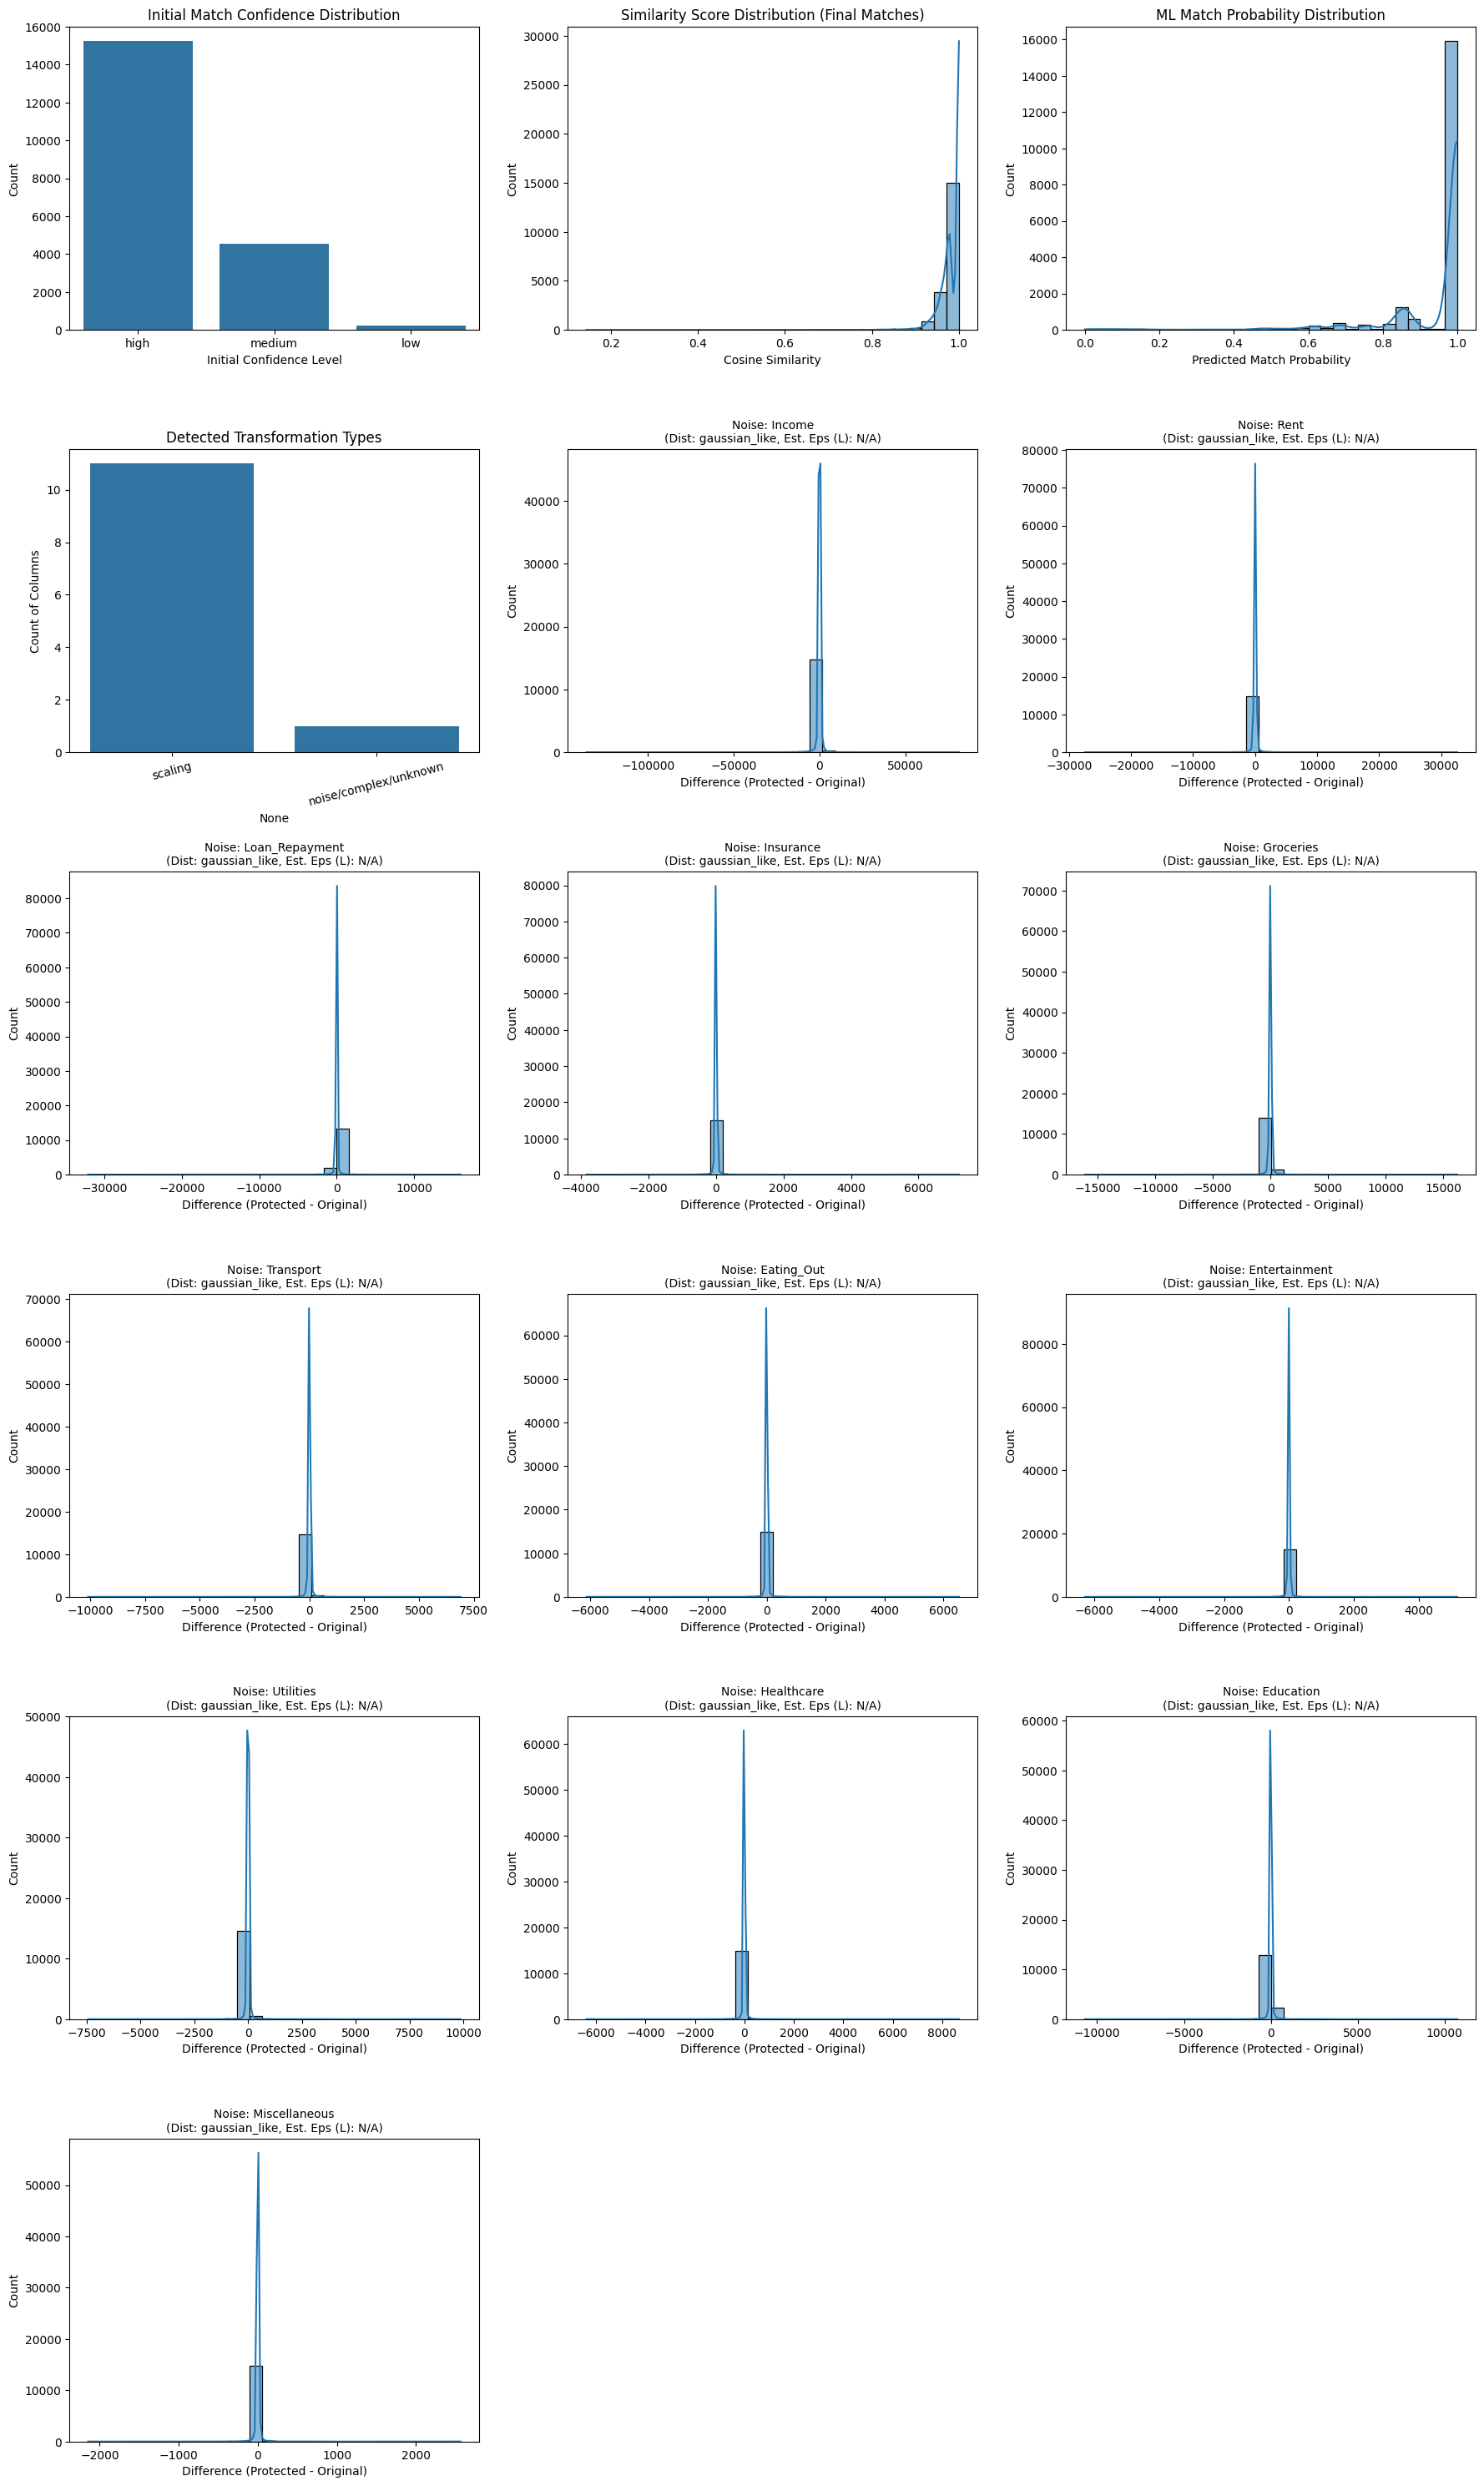

Evaluation complete.
------------------------------


In [12]:


def evaluate_results_enhanced(matches_df, protected_df, original_df, transformations, noise_results):
    """Evaluate results including noise analysis and create enhanced visualizations."""
    print("Calculating final summary statistics...")
    # --- Summary Stats ---
    total_records = len(protected_df)
    # Use initial confidence for these counts
    conf_counts = matches_df['confidence'].value_counts()
    high_conf = conf_counts.get('high', 0)
    medium_conf = conf_counts.get('medium', 0)
    low_conf = conf_counts.get('low', 0)
    match_rate_hi_med = (high_conf + medium_conf) / total_records if total_records > 0 else 0
    # Get refinement counts (check if columns exist)
    ml_refined_count = matches_df['ml_refined'].sum() if 'ml_refined' in matches_df.columns else 0
    dist_refined_count = matches_df['distance_refined'].sum() if 'distance_refined' in matches_df.columns else 0

    report = {
        'total_records': total_records,
        'high_confidence_matches': high_conf,
        'medium_confidence_matches': medium_conf,
        'low_confidence_matches': low_conf,
        'match_rate_hi_med': match_rate_hi_med,
        'ml_refined_count': ml_refined_count,
        'distance_refined_count': dist_refined_count,
        'transformations_summary': transformations,
        'noise_analysis': noise_results
    }

    print("Generating visualizations...")
    # --- Visualizations ---
    # Dynamically determine number of plots needed
    num_base_plots = 4
    num_noise_plots = sum(1 for col, details in noise_results.items() if details.get('samples', 0) >= MIN_SAMPLES_FOR_NOISE_FIT)
    num_plots = num_base_plots + num_noise_plots
    num_cols = 3 # Adjust layout columns
    num_rows = int(np.ceil(num_plots / num_cols))
    plt.figure(figsize=(6 * num_cols, 5 * num_rows))
    plot_index = 1

    # Plot 1: Initial Confidence distribution
    plt.subplot(num_rows, num_cols, plot_index); plot_index+=1
    sns.barplot(x=conf_counts.index, y=conf_counts.values, order=['high', 'medium', 'low'])
    plt.title('Initial Match Confidence Distribution')
    plt.ylabel('Count'); plt.xlabel('Initial Confidence Level')

    # Plot 2: Final Similarity score distribution (of the final assigned match)
    plt.subplot(num_rows, num_cols, plot_index); plot_index+=1
    sns.histplot(matches_df['similarity'], bins=30, kde=True)
    plt.title('Similarity Score Distribution (Final Matches)')
    plt.xlabel('Cosine Similarity'); plt.ylabel('Count')

    # Plot 3: ML Match Probability (if available)
    plt.subplot(num_rows, num_cols, plot_index); plot_index+=1
    if USE_ML_REFINEMENT and 'ml_match_probability' in matches_df.columns:
        sns.histplot(matches_df['ml_match_probability'], bins=30, kde=True)
        plt.title('ML Match Probability Distribution')
        plt.xlabel('Predicted Match Probability'); plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'ML Refinement Skipped or Failed', ha='center', va='center', fontsize=12)
        plt.title('ML Match Probability Distribution')
        plt.xticks([]); plt.yticks([])

    # Plot 4: Transformation analysis summary
    plt.subplot(num_rows, num_cols, plot_index); plot_index+=1
    if transformations:
         transform_types = [t.get('type', 'unknown') for t in transformations.values()]
         plot_types = ['scaling' if 'scaling' in t else 'shift' if 'shift' in t else 'noise/complex/unknown' for t in transform_types]
         transform_counts = pd.Series(plot_types).value_counts()
         if not transform_counts.empty:
             sns.barplot(x=transform_counts.index, y=transform_counts.values)
             plt.title('Detected Transformation Types')
             plt.ylabel('Count of Columns'); plt.xticks(rotation=15)
         else:
             plt.text(0.5, 0.5, 'No specific transformations detected', ha='center', va='center')
             plt.title('Detected Transformation Types'); plt.xticks([]); plt.yticks([])
    else:
         plt.text(0.5, 0.5, 'Transformation analysis skipped', ha='center', va='center')
         plt.title('Detected Transformation Types'); plt.xticks([]); plt.yticks([])

    # Plots 5+: Noise Distribution Histograms
    # Get indices for high-confidence matches to plot noise accurately
    high_conf_match_indices = matches_df[matches_df['confidence'] == 'high']['protected_idx']
    high_conf_orig_indices = matches_df[matches_df['confidence'] == 'high']['original_idx']
    # Align indices again, ensure they exist in respective dataframes
    valid_p_indices_plot = high_conf_match_indices[high_conf_match_indices.isin(protected_df.index)]
    valid_o_indices_plot = high_conf_orig_indices[high_conf_orig_indices.isin(original_df.index)]
    common_indices_map_plot = matches_df[
        matches_df['protected_idx'].isin(valid_p_indices_plot) &
        matches_df['original_idx'].isin(valid_o_indices_plot) &
        (matches_df['confidence'] == 'high') # Ensure we only use high-confidence for noise plots
    ]


    for col, details in noise_results.items():
        # Only plot if enough samples and analysis was successful
        if details.get('samples', 0) >= MIN_SAMPLES_FOR_NOISE_FIT and details.get('distribution') not in ['unknown', 'insufficient_data', 'fit_error']:
             # Check if we are exceeding plot grid size (safety)
             if plot_index > num_rows * num_cols: break
             plt.subplot(num_rows, num_cols, plot_index); plot_index+=1

             # Recalculate noise for plotting using aligned high-confidence indices
             if col in protected_df.columns and col in original_df.columns and not common_indices_map_plot.empty:
                 p_vals_plot = protected_df.loc[common_indices_map_plot['protected_idx'], col].values
                 o_vals_plot = original_df.loc[common_indices_map_plot['original_idx'], col].values
                 valid_mask_plot = pd.notna(p_vals_plot) & pd.notna(o_vals_plot)
                 noise_plot = p_vals_plot[valid_mask_plot] - o_vals_plot[valid_mask_plot]
                 noise_plot = noise_plot[np.isfinite(noise_plot)] # Clean finite values for plotting

                 if len(noise_plot) > 1: # Need >1 point to plot hist
                     sns.histplot(noise_plot, kde=True, bins=30)
                     dist_type = details.get('distribution', 'unknown')
                     est_eps_laplace = details.get('estimated_epsilon_laplace', 'N/A')
                     # Format title carefully to handle non-numeric epsilon estimates
                     eps_str = f"{est_eps_laplace:.2f}" if isinstance(est_eps_laplace, float) else str(est_eps_laplace)
                     title = f"Noise: {col}\n(Dist: {dist_type}, Est. Eps (L): {eps_str})"
                     plt.title(title, fontsize=10)
                     plt.xlabel('Difference (Protected - Original)'); plt.ylabel('Count')
                 else:
                      plt.text(0.5, 0.5, f'No valid noise data\nto plot for {col}', ha='center', va='center')
                      plt.title(f"Noise: {col}"); plt.xticks([]); plt.yticks([])
             else:
                  plt.text(0.5, 0.5, f'Column or index error\nplotting noise for {col}', ha='center', va='center')
                  plt.title(f"Noise: {col}"); plt.xticks([]); plt.yticks([])


    plt.tight_layout(pad=1.5) # Adjust padding
    plot_filename = 'privacy_analysis_results_enhanced.png'
    try:
        plt.savefig(plot_filename)
        print(f"Enhanced results visualization saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving visualization: {e}")
    plt.show() # Display the plot in the notebook

    return report

print("Evaluating final results and generating visualizations...")
# Evaluate results using the final matches dataframe from Step 5
results = evaluate_results_enhanced(matches_df_final, protected_data, original_data, transformations, noise_analysis_results)
print("Evaluation complete.")
print("-" * 30)

## 10. Save Results

Save the final matched records DataFrame to a CSV file and generate a detailed text report summarizing the findings, including transformation analysis, noise characteristics, and epsilon estimates.

In [13]:

print("Saving results...")
output_match_file = 'matched_records_final.csv'
output_analysis_file = 'full_analysis_report.txt'

try:
    matches_df_final.to_csv(output_match_file, index=False)
    print(f"Final matched records saved to {output_match_file}")
except Exception as e:
    print(f"Error saving matched records CSV: {e}")

try:
    with open(output_analysis_file, 'w') as f:
        f.write("="*40 + "\n")
        f.write(" Adversarial Attack Analysis Report\n")
        f.write("="*40 + "\n\n")

        f.write("I. Matching Summary:\n")
        f.write(f"  Total protected records: {results['total_records']}\n")
        f.write(f"  Initial High confidence matches: {results['high_confidence_matches']}\n")
        f.write(f"  Initial Medium confidence matches: {results['medium_confidence_matches']}\n")
        f.write(f"  Initial Low confidence matches: {results['low_confidence_matches']}\n")
        f.write(f"  Initial Match Rate (High + Medium): {results['match_rate_hi_med']:.2%}\n")
        f.write(f"  Matches potentially changed by ML Refinement: {results['ml_refined_count']}\n")
        f.write(f"  Matches potentially changed by Distance Refinement: {results['distance_refined_count']}\n")
        f.write("\n" + "-"*30 + "\n\n")

        f.write("II. Transformation Analysis Summary (from high-confidence pairs):\n")
        if results['transformations_summary']:
            for col, transform in results['transformations_summary'].items():
                # Provide a cleaner summary
                ttype = transform.get('type','unknown')
                details_str = ""
                if ttype == 'scaling':
                    details_str = f"Factor ~{transform.get('factor', np.nan):.4f} (Ratio StdDev: {transform.get('consistency_ratio_std', np.nan):.4f})"
                    if 'shift_component_mean' in transform:
                        details_str += f", Shift Component ~{transform.get('shift_component_mean', np.nan):.2f} (StdDev: {transform.get('shift_component_std', np.nan):.2f})"
                elif ttype == 'shift':
                    details_str = f"Value ~{transform.get('value', np.nan):.2f} (Diff StdDev: {transform.get('consistency_diff_std', np.nan):.2f})"
                elif ttype == 'noise_or_complex':
                     details_str = f"Complex/Noise (Diff Mean: {transform.get('diff_mean', np.nan):.2f}, Diff StdDev: {transform.get('diff_std', np.nan):.2f})"

                f.write(f"  - {col}: Type={ttype}, Details=({details_str})\n")
        else:
            f.write("  Transformation analysis was skipped or failed.\n")
        f.write("\n" + "-"*30 + "\n\n")

        f.write("III. Noise Analysis and Epsilon Estimation (from high-confidence pairs):\n")
        f.write(f"  Note: Epsilon estimates depend heavily on ASSUMED sensitivity values.\n")
        # Convert sensitivity dict to a more readable string
        sensitivity_str = ", ".join([f"{k}={v}" for k,v in sensitivity_map.items()])
        f.write(f"  Assumed Sensitivities: {{ {sensitivity_str} }}\n\n")
        if results['noise_analysis']:
            for col, details in results['noise_analysis'].items():
                 # Only report columns where analysis was attempted and potentially successful
                 if details.get('samples', 0) >= MIN_SAMPLES_FOR_NOISE_FIT and details.get('distribution') != 'unknown':
                     f.write(f"  - Column: {col}\n")
                     f.write(f"    Noise Samples: {details.get('samples', 0)}\n")
                     f.write(f"    Noise Mean: {details.get('mean', np.nan):.2f}\n")
                     f.write(f"    Noise Std Dev: {details.get('std_dev', np.nan):.2f}\n")
                     f.write(f"    Inferred Noise Dist.: {details.get('distribution', '?')}\n")
                     # Report fit parameters if available
                     if 'gaussian_fit' in details: f.write(f"    Gaussian Fit (loc, scale): ({details['gaussian_fit']['loc']:.2f}, {details['gaussian_fit']['scale']:.2f})\n")
                     if 'laplace_fit' in details: f.write(f"    Laplace Fit (loc, scale): ({details['laplace_fit']['loc']:.2f}, {details['laplace_fit']['scale']:.2f})\n")
                     # Report Epsilon estimates clearly
                     eps_l = details.get('estimated_epsilon_laplace', 'N/A')
                     eps_g = details.get('estimated_epsilon_gaussian', 'N/A')
                     gs_ratio = details.get('gaussian_scale_sensitivity_ratio', 'N/A')
                     f.write(f"    Est. Epsilon (if Laplace): {eps_l if isinstance(eps_l, str) else f'{eps_l:.4f}'}\n")
                     f.write(f"    Est. Epsilon (if Gaussian): {eps_g} ")
                     if isinstance(gs_ratio, float): f.write(f"(Scale/Sensitivity Ratio: {gs_ratio:.4f})\n")
                     else: f.write("\n")
                     f.write("\n")
        else:
            f.write("  Noise analysis was skipped or failed.\n")
        f.write("\n" + "="*40 + "\n")
    print(f"Full analysis report saved to {output_analysis_file}")
except Exception as e:
    print(f"Error saving analysis report: {e}")
print("-" * 30)

Saving results...
Final matched records saved to matched_records_final.csv
Error saving analysis report: name 'sensitivity_map' is not defined
------------------------------


## 11. Final Summary Output

Print a concise summary of the key results to the console.

In [14]:


print(f"Total protected records: {results.get('total_records', 'N/A')}")
print(f"Initial High/Medium Confidence Rate: {results.get('match_rate_hi_med', 0):.2%}")
if USE_ML_REFINEMENT:
    print(f"Matches potentially changed by ML: {results.get('ml_refined_count', 'N/A')}")
print(f"Matches potentially changed by Distance Refinement: {results.get('distance_refined_count', 'N/A')}")

# Summarize key Epsilon finding
key_eps = {}
if results.get('noise_analysis'):
     key_eps = {col: details.get('estimated_epsilon_laplace', np.inf)
               for col, details in results['noise_analysis'].items()
               if isinstance(details.get('estimated_epsilon_laplace'), float) and details.get('distribution') != 'insufficient_data'} # Check type and validity

if key_eps:
    try:
        min_eps_col = min(key_eps, key=key_eps.get)
        print(f"Lowest Estimated Epsilon (Laplace Assumption): ~{key_eps[min_eps_col]:.2f} for column '{min_eps_col}'")
    except ValueError: # Handle case where key_eps might be empty after filtering
        print("Could not determine lowest estimated Epsilon.")
else:
    print("Epsilon estimation results not available or invalid.")

print(f"\nCheck '{output_analysis_file}' and 'privacy_analysis_results_enhanced.png' for full details.")
print("="*75)

print("\nAnalysis complete.")


============================== Final Summary ==============================
Total protected records: 20000
Initial High/Medium Confidence Rate: 98.91%
Matches potentially changed by ML: 558
Matches potentially changed by Distance Refinement: 801
Epsilon estimation results not available or invalid.

Check 'full_analysis_report.txt' and 'privacy_analysis_results_enhanced.png' for full details.

Analysis complete.
